# Imports

In [1]:
from time import perf_counter, gmtime, strftime

In [2]:
import numpy as np
import numpy.linalg as la

In [3]:
from doframework.core.hit_and_run import hit_and_run_square_test, hit_and_run
from doframework.core.hit_and_run import get_hull, scale, box_sample, plot_polytope, rounding, in_domain
from doframework.core.hit_and_run import warm_start as sample_by_exclusion

# Global parameters

In [4]:
tol = 1e-8
num_cpus = 4

# Hit & Run

This notebook demonstrates the use of the Hit & Run algorithm to sample points from a Gaussian restricted to a polytope. The Hit & Run algorithm is good for convex bodies more generally.

Our implementation follows the work of **Ben Cousins** in *Efficient High-dimensional Sampling and Integration* (PhD Thesis, 2017).

### Hyper-Parameters

* ```sigma_sq```: the variance of the spherical Gaussian to be sampled.
* ```delta```: the variance of the spherical Gaussian that serves as a warm start for Hit & Run.
* ```N```: the number of samples to sample.
* ```T```: the mixing time for the Hit & Run walk.

In [5]:
sigma_sq = 1.0
delta = 0.1
N = 2000
T = 20

### Test

First, let's run a test for the Hit & Run algorithm. We will sample a small spherical Gaussian inside a large square. We expect to sample from a multivariate normal distribution -- restriction to the large square should not have an effect. Our sample should pass a normality test (we will use Henze-Zirkler).

We will project the Hit & Run samples on one of the coordinates and see how it compares to the Gaussian with the sam variance.

We will also one iteration of Hit & Run. In a nutshell, a chord is established in a randon direction through the current point. Then, a point is sampled from the $1$-dimensional Gaussian projected onto this chord. The point is rejected if it outside the polytope. And so on it goes.

Henze-Zirkler multivariate normality sample test: True


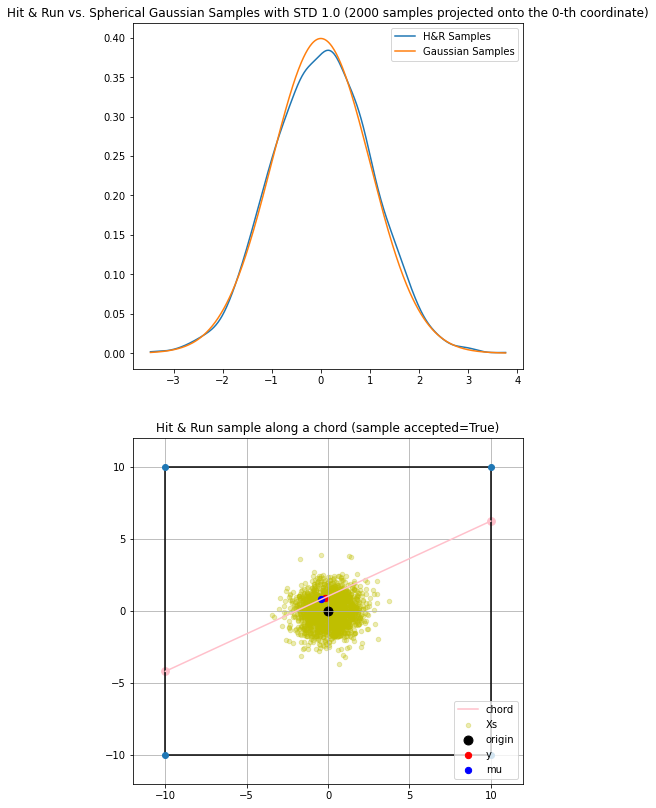

In [6]:
hit_and_run_square_test(N=N, T=T, sigma_sq=sigma_sq, delta=delta, num_cpus=num_cpus, tol=tol, figsize=(7,14))

### 2D Polytope

We will use the Hit & Run algorithm to sample *uniformally* from some ranodm $2$-dimensional polytopes.

The random polytope will be sampled as the convex hull of $P$ ransom points in a box $B$.

In [7]:
box_lows = [-1,-1]
box_highs = [1,1]

assert len(box_lows)==len(box_highs), 'Box dimension mismatch.'

d = len(box_lows)

Number $N$ of sampled points to generate the polytope.

In [8]:
P = 10

In [9]:
points = box_sample(box_lows,box_highs,d,P)

In [10]:
hull, vertices, simplices = get_hull(points)

The algorithm assumes there's a unit ball inside the polytope. Hence, we'll shift relative to the center of mass and scale. 

Note that Hit & Run assumes we have one point inside the convex body to begin with. This is easy with a polytope.

In [11]:
cm = np.average(vertices,axis=0)[None,:]
ratio = scale(cm, simplices[:,0,:], hull.equations[:,:-1])

points = (points-cm)/ratio 
hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

We'll now run the algorithm. Note that we do not provide the variance. The algorithm will sample uniformally by default.

We provide ```num_cpus``` to parallelize the sampling process across various workers.

In [12]:
X = hit_and_run(N,origin,hull.equations,T,delta,num_cpus=num_cpus,tol=tol)

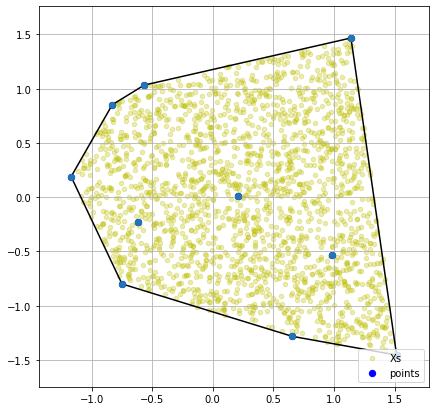

In [13]:
plot_polytope(hull, X=X)

## 3D

We will use the Hit & Run algorithm to sample a spherical Gaussian restricted to some ranodm $3$-dimensional polytopes.

Again, the random polytope will be sampled as the convex hull of $P$ ransom points in a box $B$.

In [14]:
box_lows = [-1,-1,-1]
box_highs = [1,1,1]

assert len(box_lows)==len(box_highs), 'Box dimensions mismatch.'

d = len(box_lows)

In [15]:
P = 20

In [16]:
points = box_sample(box_lows,box_highs,d,P)

In [17]:
hull, vertices, simplices = get_hull(points)

Ensure a unit ball inside generated polytope around center of mass.

In [18]:
cm = np.average(vertices,axis=0)[None,:]
ratio = scale(cm, simplices[:,0,:], hull.equations[:,:-1])

points = (points-cm)/ratio 
hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

Let's change the parameters a big.

In [19]:
sigma_sq = 0.8
N = 1000
T = 10

In [20]:
X = hit_and_run(N,origin,hull.equations,T,delta,sigma_sq=sigma_sq,num_cpus=num_cpus,tol=tol)

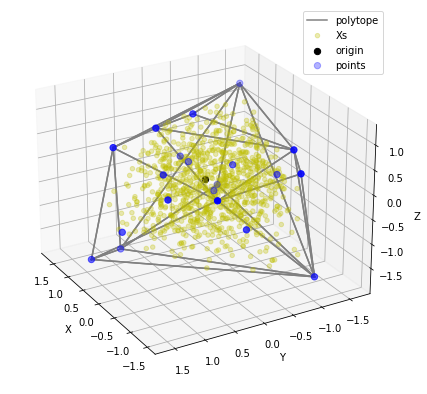

In [21]:
plot_polytope(hull, origin, X)

### Exclusion

Let's compare Hit & Run to sampling by exclusion. We'll use the same $3$-dimensional polytope above.

Sampling by exclusion would be more or less unfeasible when the dimension $d>5$ (certainly on a local machine).

In [22]:
Y = sample_by_exclusion(origin,hull.equations,sigma_sq,N)

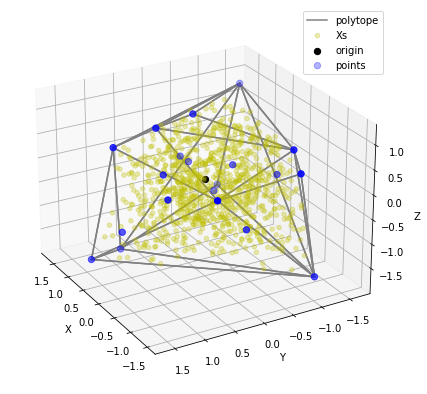

In [23]:
plot_polytope(hull, origin, Y)

### High D

We will now test the Hit & Run algorithm in higher dimensions. 

We need to be careful here. As we go up in dimension, the number of faces of a randomly sampled polytope baloons, the more points $P$ we have (up to some saturation level). Hit & Run performance is linear in the number of faces.

In [24]:
box_lows = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
box_highs = [1,1,1,1,1,1,1,1,1,1,1,1]

assert len(box_lows)==len(box_highs), 'Box dimensions mismatch.'

d = len(box_lows)

print(f'Running in dimension: {d}')

Running in dimension: 12


Sampling polytope as the convex hull of $P$ points inside the box $B$.

In [25]:
P = 25

In [26]:
points = box_sample(box_lows,box_highs,d,P)
hull, vertices, simplices = get_hull(points)

Ensure a unit ball inside generated polytope around center of mass.

In [27]:
cm1 = np.average(vertices,axis=0)[None,:]
ratio1 = scale(cm1, simplices[:,0,:], hull.equations[:,:-1])

points = (points-cm1)/ratio1
hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]
print('Number of faces of polytope:',simplices.shape[0])

Number of faces of polytope: 16256


We perform a rounding step to facilitate sampling in higher dimensions. Rounding will make it less likely that Hit & Run will run into sharp conrners.

Rounding is a linear transformation which we can later reverse apply to get a Gaussian sample of the original polytope (though not necessarily spherical).

In [28]:
points, A = rounding(points, tol=tol)
hull, vertices, simplices = get_hull(points)

We'll shift to the origin and scale to ensure unit ball inside again.

In [29]:
cm2 = np.average(vertices,axis=0)[None,:]
ratio2 = scale(cm2, simplices[:,0,:], hull.equations[:,:-1])

points = (points-cm2)/ratio2
hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

Here are the Hit & Run parameters again.

In [30]:
sigma_sq = 1.1
delta = 0.2
N = 1000
T = 20

In [31]:
t1 = perf_counter()
X = hit_and_run(N,origin,hull.equations,T,delta,sigma_sq=sigma_sq,num_cpus=num_cpus,tol=tol)
t2 = perf_counter()

In [32]:
t = strftime("%H:%M:%S",gmtime(t2-t1))
print(f"Hit & Run Convex Polytope Sampling:\nDimension: {d}\nN: {N}\nH&R Tries: {N*T}\nVariance: {sigma_sq:.1f}\nMix Time: {T}\nTime: {t} (HH:MM:SS)")

Hit & Run Convex Polytope Sampling:
Dimension: 12
N: 1000
H&R Tries: 20000
Variance: 1.1
Mix Time: 20
Time: 00:00:36 (HH:MM:SS)


Now we can reverse transform back to the original polytope. We get a Gaussian sample restricted to the polytope.

In [33]:
X = ratio2*X+cm2
X = X@la.inv(A)
X = ratio1*X+cm1

In [34]:
print('SANITY: Gaussian samples inside polytope:',np.all(in_domain(X, hull.equations, tol=tol)))
print('SANITY: number of unique Gaussian samples:',np.unique(X,axis=1).shape[0])

SANITY: Gaussian samples inside polytope: True
SANITY: number of unique Gaussian samples: 1000
